In [2557]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import stats

Read Gold (D1) data:

In [2558]:
dfG=pd.read_csv('quotes/AU(D).csv') 
dfG.columns=['date','time','open','high','low','close','volume'] 
dfG=dfG[['date','open','close','low','high']]
dfG.set_index('date',inplace=True)
dfG=dfG.drop(['high','low','open'], axis=1) 
dfG.rename(columns={'close':'closeG'},inplace=True)
dfG.index=pd.to_datetime(dfG.index)
dfG.head(0)

,closeG
date,


Read Silver (D1) data:

In [2559]:
dfS=pd.read_csv('quotes/AG(D).csv') 
dfS.columns=['date','time','open','high','low','close','volume'] 
dfS=dfS[['date','open','close','low','high']]
dfS.set_index('date',inplace=True)
dfS=dfS.drop(['high','low','open'], axis=1) 
dfS.rename(columns={'open':'openS','close':'closeS'},inplace=True)
dfS.index=pd.to_datetime(dfS.index)
dfS.head(0)

,closeS
date,


Merging of 2 frames by indexes:

In [2560]:
df=pd.merge(dfS,dfG,how='inner',left_index=True,right_index=True)
df=df.dropna()
df.head()

,closeS,closeG
date,,
2011-09-28,29.893,1608.23
2011-09-29,30.592,1614.27
2011-09-30,29.671,1623.23
2011-10-03,30.390,1660.63
2011-10-04,30.183,1624.38


Convert prices to returns by log function and taking differences:

In [2561]:
df=df[['closeS','closeG']].apply(np.log)
df=df.diff(axis=0,periods=1)
df=df.dropna()
df.head()

,closeS,closeG
date,,
2011-09-29,0.023114,0.003749
2011-09-30,-0.030568,0.005535
2011-10-03,0.023943,0.022779
2011-10-04,-0.006835,-0.022071
2011-10-05,0.009332,0.010356


Normalize returns to avoid model instability:

In [2562]:
df=(df-df.min())/(df.max()-df.min())
df=df.dropna()
df.head()

,closeS,closeG
date,,
2011-09-29,0.777206,0.693015
2011-09-30,0.525478,0.705465
2011-10-03,0.781094,0.825640
2011-10-04,0.636770,0.513077
2011-10-05,0.712581,0.739065


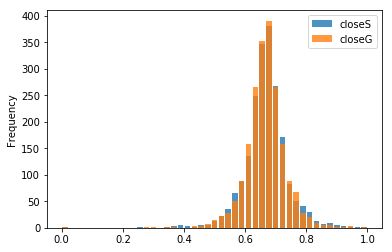

In [2563]:
df[['closeS','closeG']].plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,alpha=0.8)
plt.show()

In [2564]:
df.describe()

,closeS,closeG
count,2045.000000,2045.000000
mean,0.667683,0.666740
std,0.070409,0.064918
min,0.000000,0.000000
25%,0.633530,0.633333
50%,0.669060,0.668058
75%,0.701522,0.699748
max,1.000000,1.000000


Look at the outliers:

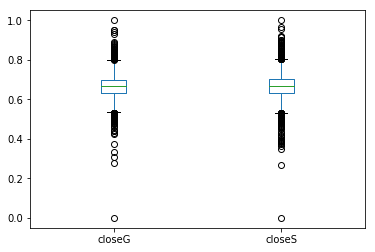

In [2565]:
df[['closeG','closeS']].boxplot(grid=False) 
plt.show()

We may remove some outliers - we ignore them in future pipeline:

In [2566]:
df=df[df[['closeG','closeS']]>0.2]
df=df.dropna()

Create scatter plot of Gold vs Silver:

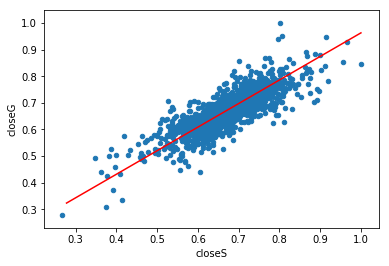

In [2567]:
df.plot.scatter(x='closeS',y='closeG')
plt.plot(np.unique(df['closeG']),np.poly1d(np.polyfit(df['closeG'], df['closeS'], 1))(np.unique(df['closeG'])),color='r')
plt.show()

Look at the relative return:

In [2568]:
df['Relative return']=df['closeG']/df['closeS']
description=df['Relative return'].describe()
print(description)

mean=description[1]
std=description[2]

u1=round(mean+std,2)
l1=round(mean-std,2)

count    2044.000000
mean        1.001477
std         0.063715
min         0.725368
25%         0.966051
50%         0.999828
75%         1.032229
max         1.418389
Name: Relative return, dtype: float64


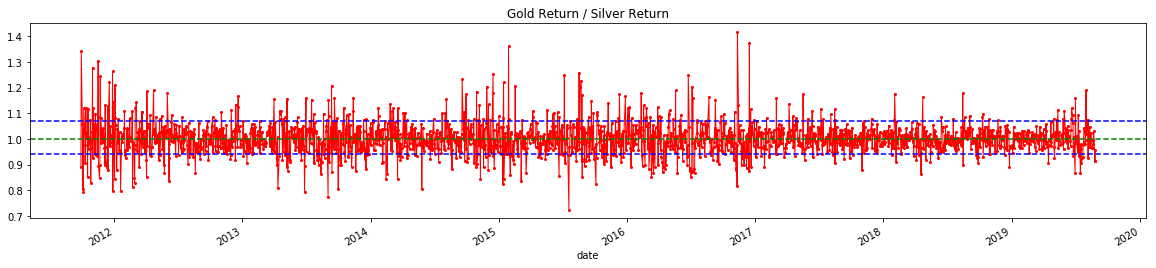

In [2569]:
plt.figure(figsize=(20,4))
df['Relative return'].plot(color='r',marker='o',linewidth=1, markersize=2)

plt.axhline(y=mean,color='g',linestyle='--')
plt.axhline(y=u1,color='b',linestyle='--')
plt.axhline(y=l1,color='b',linestyle='--')

plt.title('Gold Return / Silver Return')
plt.show()

Median (50%) is close to the average value. The distribution is quite close to ND except outliers. Horisontal lines show the mean an the range where the relative return is observed with probability of 70% for Normal Distribution - 1 sigma decline.

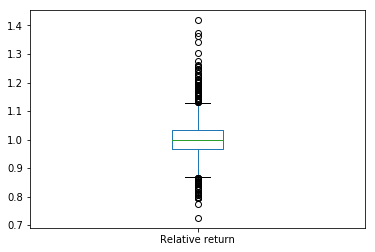

In [2570]:
dfR=df['Relative return']
dfR.plot.box(grid=False) 
plt.show()

Relative return seems to be mean reverting to the parity. Let's check linear regression with cross validation:

In [2571]:
df['closeS1']=df['closeS'] 
df.rename(columns={'closeS':'closeS0'},inplace = True)
df=df[['closeS0','closeS1','closeG','Relative return']]

array=df.values

X=array[:,0:2]
Y=array[:,2]

kfold=KFold(n_splits=10,random_state=7)
model=LinearRegression()
model.fit(X,Y)

results=cross_val_score(model,X,Y,cv=kfold,scoring='r2')
print('Average R2:',int(100*round(results.mean(),2)),'%')
print('Scattering of R2:',int(100*round(results.std(),2)),'%')

Average R2: 65 %
Scattering of R2: 7 %


Score is quite stable to resampling. 
Now we check the relative return for stationarity by ADF test: 

In [2572]:
z=df['Relative return'].values
result=adfuller(z)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -47.692177
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


We can reject the HO of time series stationarity.

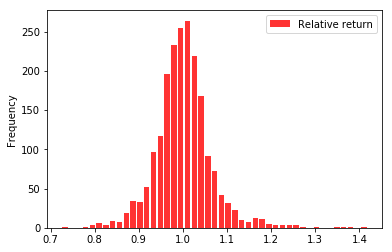

In [2573]:
df[['Relative return']].plot.hist(bins=int(np.sqrt(len(df))),rwidth=0.8,alpha=0.8,color='r')
plt.show()

Now we may move to the "where we are now?" => 27.08.19. Let's display last records:

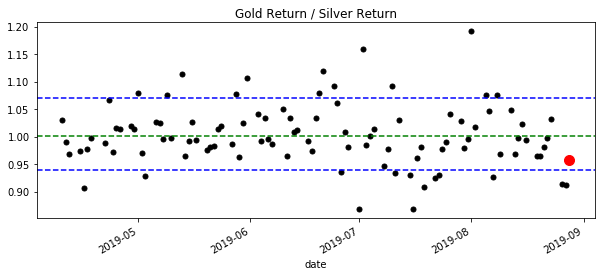

In [2574]:
df=df.iloc[-100:]
plt.figure(figsize=(10,4))

df['Relative return'].plot(color='black',marker='o',linestyle='dashed',linewidth=0, markersize=5)
plt.axhline(y=mean,color='g',linestyle='--')
plt.axhline(y=u1,color='b',linestyle='--')
plt.axhline(y=l1,color='b',linestyle='--')

plt.title('Gold Return / Silver Return')
plt.plot(df['Relative return'].index[-1], df['Relative return'].values[-1],'or',markersize=10)
plt.show()